In [1]:
import os
import numpy as np
import pandas as pd

import glob
import copy

import matplotlib.pyplot as plt
import seaborn as sns

In [159]:
timesteps = []
results = []
for i in range(10):
    ev = np.load(f'results/expert{i}/evaluations.npz')
    timesteps.append(ev['timesteps'])
    results.append(ev['results'])

timestep = np.array(timesteps)[0]
results = np.array(results)
results = results.transpose(1,0,2).reshape(123, -1)
results.shape

(123, 50)

In [280]:
glob.glob('results/noob*/evaluations.npz')

['results/noob30403/evaluations.npz',
 'results/noob41993/evaluations.npz',
 'results/noob57043/evaluations.npz',
 'results/noob43567/evaluations.npz',
 'results/noob21243/evaluations.npz',
 'results/noob2732/evaluations.npz',
 'results/noob32103/evaluations.npz',
 'results/noob52416/evaluations.npz',
 'results/noob45891/evaluations.npz',
 'results/noob42613/evaluations.npz']

In [7]:
data_expert = []
for file in glob.glob('results/expert*/evaluations.npz'):
    ev = np.load(file)
    for i in range(5):
        data_expert.append(pd.DataFrame({'timesteps': ev['timesteps'],
                                       'value': ev['results'][:, i],
                                       'level': 'expert'}))
    
data_noob= []
for file in glob.glob('results/noob*/evaluations.npz'):
    ev = np.load(file)
    for i in range(5):
        data_noob.append(pd.DataFrame({'timesteps': ev['timesteps'],
                                   'value': ev['results'][:, i],
                                   'level': 'noob'}))

In [17]:
data_expert = []
for file in glob.glob('results/expert*/evaluations.npz'):
    ev = np.load(file)
    data_expert.append(pd.DataFrame({'timesteps': ev['timesteps'],
                                       'value': np.mean(ev['results'], axis=1),
                                       'level': 'expert'}))
    
data_noob= []
for file in glob.glob('results/noob*/evaluations.npz'):
    ev = np.load(file)
    data_noob.append(pd.DataFrame({'timesteps': ev['timesteps'],
                                   'value': np.mean(ev['results'], axis=1),
                                   'level': 'noob'}))

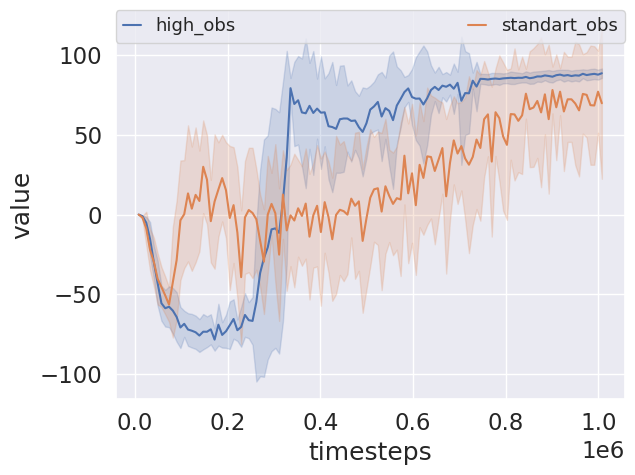

In [19]:
plt.figure()
plot_data(data_expert, smooth=1, label='high_obs')
plot_data(data_noob, smooth=1, label='standart_obs')
plt.show()

In [11]:
def plot_data(data, xaxis='timesteps', value="value", smooth=1, **kwargs):
    data = copy.deepcopy(data)
    if smooth > 1:
        """
        smooth data with moving window average.
        that is,
            smoothed_y[t] = average(y[t-k], y[t-k+1], ..., y[t+k-1], y[t+k])
        where the "smooth" param is width of that window (2k+1)
        """
        y = np.ones(smooth)
        for datum in data:
            x = np.asarray(datum[value])
            z = np.ones(len(x))
            smoothed_x = np.convolve(x,y,'same') / np.convolve(z,y,'same')
            datum[value] = smoothed_x

    if isinstance(data, list):
        data = pd.concat(data, ignore_index=True)
    sns.set(style="darkgrid", font_scale=1.5)
    sns.lineplot(data=data, x=xaxis, y=value, errorbar='sd', **kwargs)
    
    plt.legend(loc='upper center', ncol=6, handlelength=1,
               mode="expand", borderaxespad=0., prop={'size': 13})
    # plt.legend(loc='best').set_draggable(True)
    #plt.legend(loc='upper center', ncol=3, handlelength=1,
    #           borderaxespad=0., prop={'size': 13})

    """
    For the version of the legend used in the Spinning Up benchmarking page, 
    swap L38 with:
    plt.legend(loc='upper center', ncol=6, handlelength=1,
               mode="expand", borderaxespad=0., prop={'size': 13})
    """

    xscale = np.max(np.asarray(data[xaxis])) > 5e3
    if xscale:
        # Just some formatting niceness: x-axis scale in scientific notation if max x is large
        plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

    plt.tight_layout(pad=0.5)